<a href="https://colab.research.google.com/github/nmningmei/LevelUpPythonTutorial/blob/master/30_2_two_sample_t_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import random
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')
import pymc3 as pm

# let's make some data

## I control the two samples with different sample size, different variance, but their mean difference is at the borderline of significance based on a parametric paired-sample t test

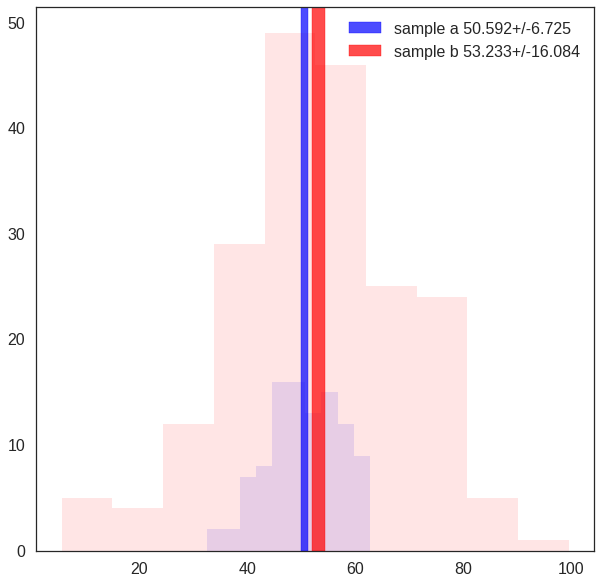

In [0]:
p = 1.0
while (p>0.05) or (p < 0.04):
    a = np.random.normal(50.,7.4,size=100)
    b = np.random.normal(53.5,15.9,size=200)
    t,p = stats.ttest_ind(a,b,equal_var=False,)
fig,ax = plt.subplots(figsize=(10,10))
ax.hist(a,color='blue',alpha=0.1)
ax.hist(b,color='red',alpha=0.1)
ax.axvspan(a.mean()-a.std()/np.sqrt(a.size),a.mean()+a.std()/np.sqrt(a.size),
           color='blue',alpha=0.7,label='sample a {:.3f}+/-{:.3f}'.format(a.mean(),a.std()))
ax.axvspan(b.mean()-b.std()/np.sqrt(b.size),b.mean()+b.std()/np.sqrt(b.size),
           color='red', alpha=0.7,label='sample b {:.3f}+/-{:.3f}'.format(b.mean(),b.std()))
ax.legend()

The data is simulated on purpose to have two distributions that are close to each other. Intuitively, the two distributions are heavily overlapped but they have different **"True means"**, different **" true standard deviations"**, and **sample sizes**. They are simulated so that the parametric t test on the data lands on the boarder line of p = 0.05.

## parametric independent t test with equal variance assumption

In [0]:
stats.ttest_ind(a,b,equal_var=True,)

Ttest_indResult(statistic=-1.5690586618433382, pvalue=0.1176954523278965)

With the assumption that the two datasets have equel variance, we DO NOT have a significant hypothesis test result. However, since the data violated the assumption that they have equal variance, we should not interpret the result to extra extents. In other words, if the data does not match to your assumptions prior to the hypothesis test, you should not trust the violated test. 

## parametric independent t test without equal variance assumption

In [0]:
stats.ttest_ind(a,b,equal_var=False,)

Ttest_indResult(statistic=-1.9921488272116328, pvalue=0.04728840590310853)

Without the assumption that they have equal variance, the hypothesis test returns a significant test result. Since this is what the data simulation intended to simulate, we could interpret the result as that the two distributions are statistically different at the alpha level of 0.05, since pvalue < 0.05. (If you don't know how to get to this conclusion, go back to read a statistics textbook.)

## Wilcoxon rank-sum statistics for two samples

In [0]:
stats.ranksums(a,b,)

RanksumsResult(statistic=-1.7761229193343342, pvalue=0.0757126593476223)

In [0]:
# Wilcoxon-Mann-Whitney statistics
stats.mannwhitneyu(a,b)

MannwhitneyuResult(statistic=8742.0, pvalue=0.037914530516910676)

With the non-parametric test equavilent to the t test, we have some significant results. The Wilcoxon rank-sum statistics is [is a non-parametric statistical hypothesis test used when comparing two related samples, matched samples, or repeated measurements on a single sample to assess whether their population mean ranks differ (i.e. it is a paired difference test)](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test). The Mann-whiteney U test is [a nonparametric test of the null hypothesis that it is equally likely that a randomly selected value from one sample will be less than or greater than a randomly selected value from a second sample.Unlike the t-test it does not require the assumption of normal distributions. It is nearly as efficient as the t-test on normal distributions.](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)

## nonparametric t test by permutation test

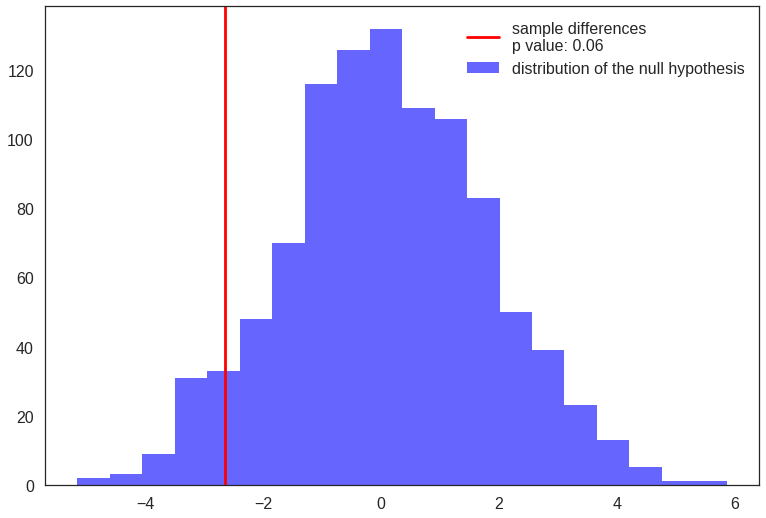

In [0]:
fig, ax = plt.subplots()
difference = np.mean(a) - np.mean(b) # compute the true difference between the two distribution. 
results=[]
for ii in range(1000): # for 1000 times do the following:
    c = np.concatenate([a,b]) # put the two dataset together
    random.shuffle(c) # shuffle the put-together dataset, so that we don't know which data point comes from which dataset
    new_a = c[:a.shape[0]]# take the first a few datapoints (same size as the "old dataset A") and consider them the "new dataset A"
    new_b = c[a.shape[0]:]# take the rest datapoints and consider them the "new dataset B"
    new_diff = new_a.mean() - new_b.mean() #compute the mean between the new two datasets. This is equavilent to randomization process
    results.append(new_diff) # to generate what the difference between A and B looks like if the data is drawn randomly from a chaos state other than the data used to be
results = np.array(results)
ax.hist(results,color='blue',alpha=0.6,bins=20, label = 'distribution of the null hypothesis')
p = min([stats.percentileofscore(results,difference,)/100,1-stats.percentileofscore(results,difference,)/100])
ax.axvline(difference,color='red',label='sample differences\np value: {:.2f}'.format(p))
ax.legend()

To do this once (within this "once", we random sampled the data 1000 times), we have a distribution of what randomzied state should look like. The read line is the difference we computed from the original data (sample difference). Based on the percentile properties, we could compute the percentile of the the sample difference at these distribution of randomized system. And it is 0.06 this time. But how robust this test? How about I test it 10000 times, or 1e6 times? After all, the randomization process is controled by the random sample process, which is the different random table starting point.

## redo the permutation test multiple times and sample the distribution of the p values

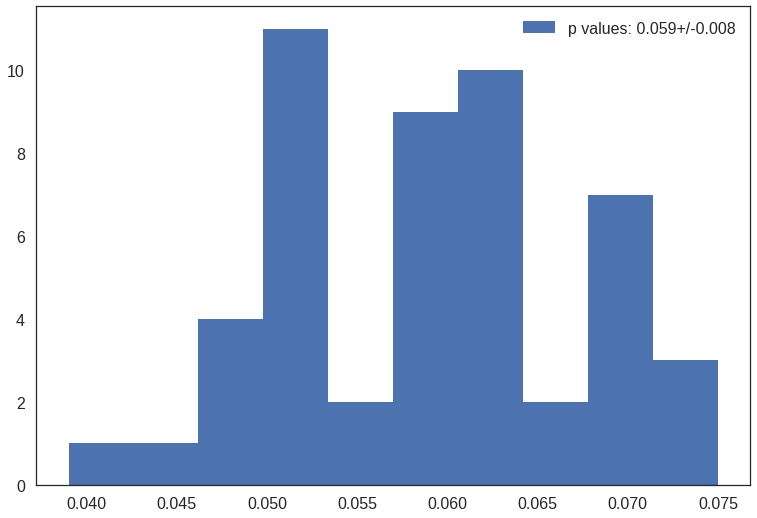

In [0]:
results = []
for ii in range(50): # redo what we did 50 times
    temp=[]
    for jj in range(1000):
        c = np.concatenate([a,b])
        random.shuffle(c)
        new_a = c[:100]
        new_b = c[100:]
        new_diff = new_a.mean() - new_b.mean()
        temp.append(new_diff)
    temp = np.array(temp)
    p=min([stats.percentileofscore(temp,difference,)/100,1-stats.percentileofscore(temp,difference,)/100])
    results.append(p)
fig, ax = plt.subplots()
ax.hist(results,bins=10,label='p values: {:.3f}+/-{:.3f}'.format(np.mean(results),np.std(results)))
ax.legend(loc='best')

# Bayesian stats

In [0]:
import pymc3 as pm

Kruschke, John (2012) **Bayesian etimation supersedes the t-test**, *Journal of Experimental Psychology:General*

$$f(x|\mu, \lambda,\v) = \frac{\Gamma(\frac{v+1}{2})}{\Gamma(\frac{v}{2})}(\frac{\lambda}{\pi v})^{\frac{1}{2}}[1+\frac{\lambda(x-\mu)^2}{v}]^{-\frac{v+1}{2}}$$

$$y_i^{\text{group a}} ~ T(v,\mu_a,\lambda_a)$$
$$y_i^{\text{group b}} ~ T(v,\mu_b,\lambda_b)$$

As a simplifying assumption, we will assume that the degree of normality $v$ is the same for both groups. We will have separate parameters for the means $\mu_k$, k = 1, 2 and standard deviations $\sigma_k$

since the means are real-valued, we will apply normal priors on them, and arbitrarily set the hyperparameters to the pooled empirical mean of the data and twice the pooled empirical standard deviation, which applies very diffuse information to these quantities (and importantly, does not favor one or the other *priori*)
$$\mu_k \approx N(\bar{x},2s)$$

In [0]:
c = np.concatenate([a,b])
c_m = c.mean()
c_s = c.std()*2
with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', c_m, sd=c_s)
    group2_mean = pm.Normal('group2_mean', c_m, sd=c_s)

In [0]:
σ_low = 6 # choose based on the data
σ_high = 20# choose based on the data

with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)

we follow the Kruschke by making the prior for $v$ exponentially distributed with a mean of 30; this allocates high prior probability over the regions of the parameters that describe the range from normal to heavy-tailed data under the Student-T distribution

In [0]:
with model:
    v = pm.Exponential('v_minus_one',1/29.) +1

In [0]:
with model:
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=v, mu=group1_mean, lam=λ1, 
                         observed=a)
    group2 = pm.StudentT('placebo', nu=v, mu=group2_mean, lam=λ2, 
                         observed=b)

In [0]:
with model:
    diff_of_means = pm.Deterministic('difference of means', 
                                     group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', 
                                    group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))

In [0]:
with model:
    trace = pm.sample(5000,init=None,njobs=1)

Sequential sampling (2 chains in 1 job)
NUTS: [v_minus_one, group2_std, group1_std, group2_mean, group1_mean]
100%|██████████| 5500/5500 [00:09<00:00, 554.12it/s]


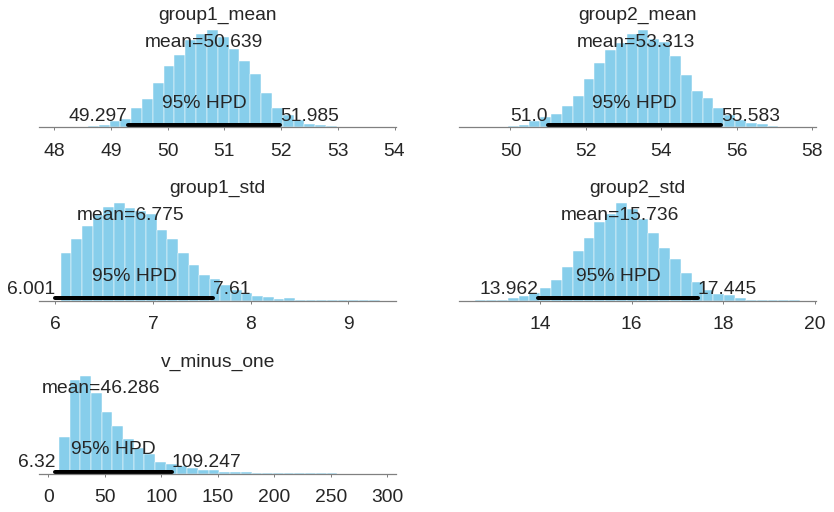

In [0]:
_=pm.plot_posterior(trace[100:],
                  varnames=['group1_mean', 
                            'group2_mean', 
                            'group1_std', 
                            'group2_std', 
                            'v_minus_one'],
                  color='#87ceeb');

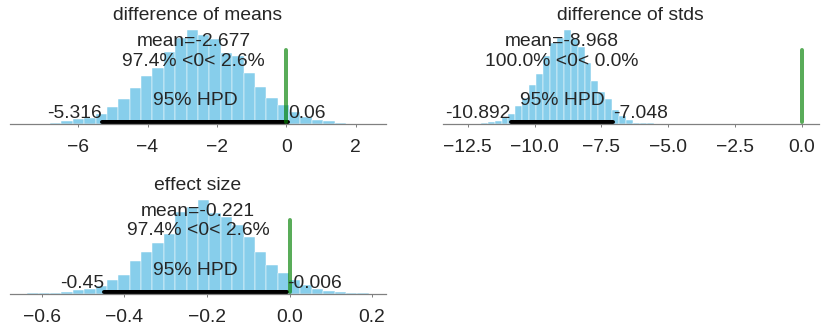

In [0]:
_=pm.plot_posterior(trace[1000:],
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')

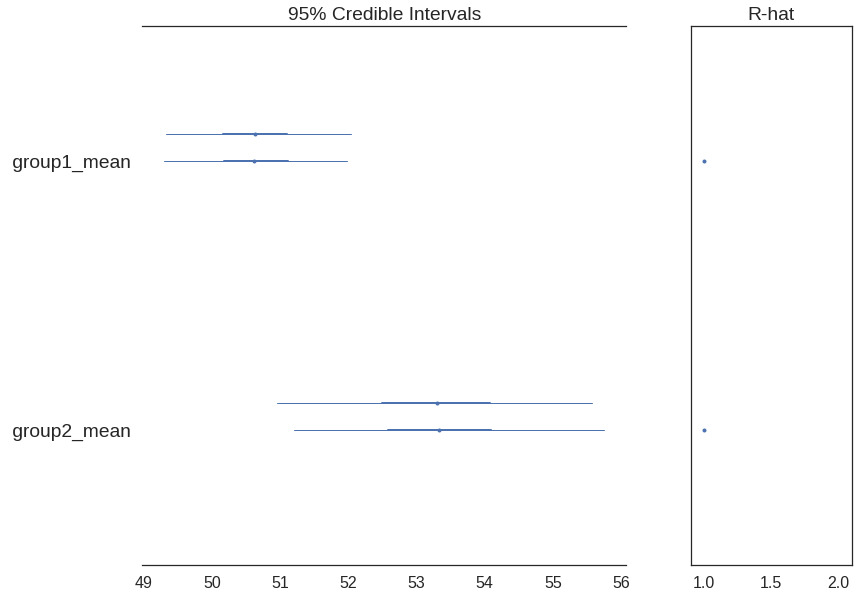

In [0]:
_=pm.forestplot(trace[1000:], 
                varnames=[v.name for v in model.vars[:2]],
           )

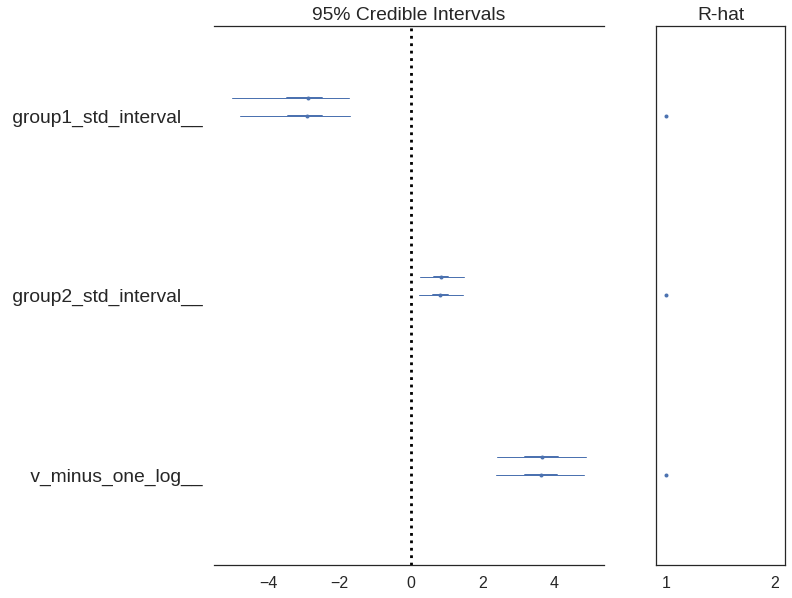

In [0]:
_=pm.forestplot(trace[1000:], varnames=[v.name for v in model.vars[2:]])

# permutation test with classification

## The idea of using classification in 2 sample t test is that since the samples are 1D vectors, in other words, 1 measure/feature. Can we use the only feature to predict which sample it belongs to?

In [0]:
from sklearn.model_selection import StratifiedKFold,permutation_test_score
from sklearn.svm import SVC

sig: 0.0033


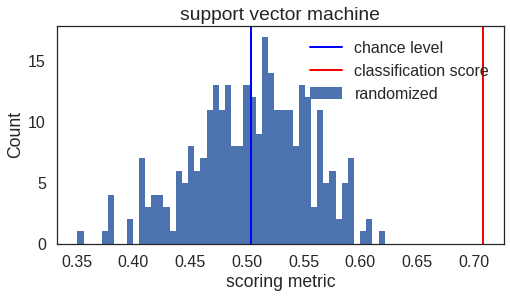

In [0]:
# label sample a `0` and label sample b `1`
label = np.concatenate([np.zeros(a.size),np.ones(b.size)])
X = np.concatenate([a,b])
#print(X.shape,label.shape)
# define cross validation method - essential in machine learning
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=12345)
# define the model we want to use for the classification
clf = SVC(class_weight='balanced',gamma = 'scale',random_state=12345)
# core of this implementation: permutation
score, permutation_scores, sig = permutation_test_score(clf,X.reshape(-1,1), # need to reshape it to a 2D matrix with the first dimension as 1
                                                        label,
                                                        cv=cv,
                                                        random_state=12345,
                                                        n_permutations=300,
                                                        scoring='roc_auc'
                                                       )

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(permutation_scores,bins=50,label='null hypothesis')
ax.axvline(np.mean(permutation_scores),color='blue',lw=2,label='chance level')
ax.axvline(score,color='red',lw=2,label='classification score')
ax.legend()
ax.set(title='support vector machine',xlabel='scoring metric',ylabel='Count')
print('sig: {:.4f}'.format(sig))

# maybe we should try some other estimators to see whether we will have the same results

In [0]:
names = ['random forest','logistic regression', 'SVM linear kernel','KNN-default','extra tree','gaussian process']
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import ExtraTreeClassifier

In [0]:
clfs = [RandomForestClassifier(n_estimators=50,class_weight='balanced',random_state=12345),
       LogisticRegression(class_weight='balanced',solver = 'lbfgs',random_state=12345),
       SVC(kernel='linear',class_weight='balanced',random_state=12345),
       KNeighborsClassifier(),
       ExtraTreeClassifier(class_weight='balanced',random_state=12345),
       GaussianProcessClassifier(random_state=12345)]

finish random forest,0.0066


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

finish logistic regression,0.1063
finish SVM linear kernel,0.1063
finish KNN-default,0.0033
finish extra tree,0.2724
finish gaussian process,0.0033


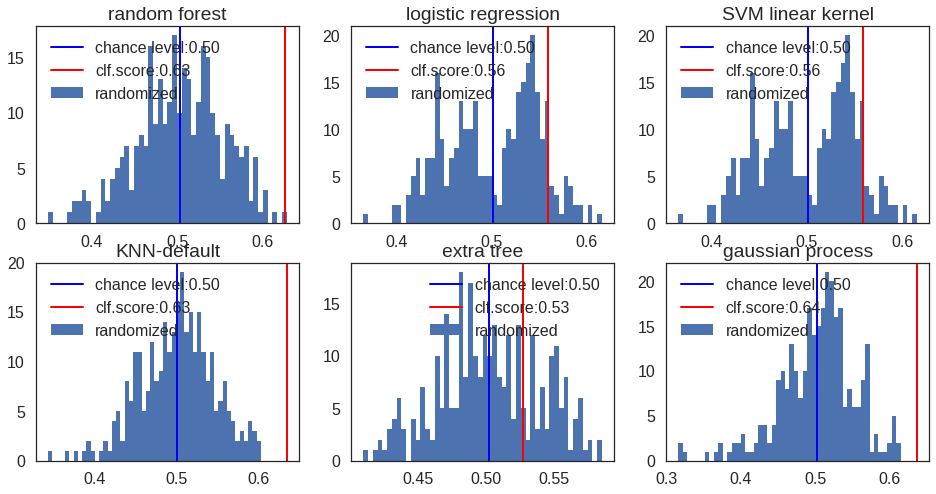

In [0]:
fig, axes = plt.subplots(figsize=(16,8),nrows=2,ncols=3)
for name,clf,ax in zip(names,clfs,axes.flatten()):
    score, permutation_scores, sig = permutation_test_score(clf,X.reshape(-1,1),label,cv=cv,random_state=12345,n_permutations=300,
                                                       scoring='roc_auc')
    ax.hist(permutation_scores,bins=50,label='randomized')
    ax.axvline(np.mean(permutation_scores),color='blue',lw=2,label='chance level:%.2f'%np.mean(permutation_scores))
    ax.axvline(score,color='red',lw=2,label='clf.score:%.2f'%score)
    ax.legend(loc='best')
    ax.set(title=name)
    print('finish {},{:.4f}'.format(name,sig))